In [1]:
import numpy as np
import sfr_tomo as cib
import pyccl as ccl
import sacc
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.interpolate import interp1d
from scipy.linalg import block_diag
import emcee
from matplotlib import rc
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})
rc('text', usetex=True)

## Read constraints on $\langle b\rho_{\rm SFR}\rangle$

In [2]:
COSMO_P18 = {"Omega_c": 0.26066676,
             "Omega_b": 0.048974682,
             "h": 0.6766,
             "n_s": 0.9665,
             "sigma8": 0.8102}
cosmo = ccl.Cosmology(**COSMO_P18)

In [3]:
s = sacc.Sacc.load_fits("data/cls_cov_minimal_newcov.fits")
nms = [f'DELS__{i}' for i in range(4)]+[f'eBOSSQSO__{i}' for i in range(2)]
nz_data = [{'name': nm,
            'zs': s.tracers[nm].z,
            'nz': s.tracers[nm].nz/np.sum(s.tracers[nm].nz),
            'z_mean': np.average(s.tracers[nm].z, weights=s.tracers[nm].nz)}
           for nm in nms]
zs = np.array([d['z_mean'] for d in nz_data])

[0.21026038 0.38402575 0.51804074 0.65964767 1.18753879 1.82402459]
[-0.00565437  0.02606994  0.04083715  0.04814109  0.10998328  0.25961848]
[0.00867026 0.00584995 0.00521995 0.00532248 0.01348039 0.0317102 ]


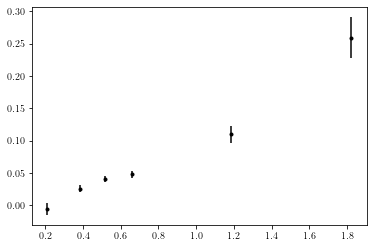

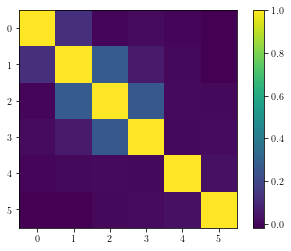

In [4]:
d = np.load("data/bSFR_kmax0p15_allbins_allfreq.npz")
data_bsfr = d['means']
cov_bsfr = d['cov']
#zs = d['zs']
plt.errorbar(zs, data_bsfr, yerr=np.sqrt(np.diag(cov_bsfr)), fmt='k.')
print(zs)
print(data_bsfr)
print(np.sqrt(np.diag(cov_bsfr)))
icov_bsfr = np.linalg.inv(cov_bsfr)
plt.figure()
plt.imshow(cov_bsfr/np.sqrt(np.diag(cov_bsfr)[None, :]*np.diag(cov_bsfr)[:, None]))
plt.colorbar()

In [5]:
mdef = ccl.halos.MassDef200c()
cM = ccl.halos.ConcentrationDuffy08(mdef)
nM = ccl.halos.MassFuncTinker10(cosmo, mdef, norm_all_z=True)
bM = ccl.halos.HaloBiasTinker10(cosmo, mdef)
hmc = ccl.halos.HMCalculator(cosmo, nM, bM, mdef)

In [6]:
def get_pred_SFR(p, convolve=True, num_z=100, SFR=False, zmax=2.3):
    zz = np.linspace(0, zmax, num_z)
    logMmax, eta_max, sigLM, tau = p
    pr.update_parameters(log10meff=logMmax, etamax=eta_max,
                         sigLM0=sigLM, tau=tau)
    if SFR:
        func = ccl.halos.halomod_mean_profile_1pt
    else:
        func = ccl.halos.halomod_bias_1pt
    bsfr = np.array([func(cosmo, hmc, 1E-4, 1/(1+z), pr)
                     for z in zz])
    if not convolve:
        return zz, bsfr
    bsfrf = interp1d(zz, bsfr, fill_value=0, bounds_error=False)
    bsfrt = np.array([np.average(bsfrf(b['zs']), weights=b['nz']) for b in nz_data])
    return bsfrt

In [7]:
import time
pr = cib.HaloProfileCIBM21(cosmo, cM, fsub=0.134, fast_integ=True)
niter = 5
start = time.time()
for i in range(niter):
    get_pred_SFR([12.94, 0.42, 1.75, 1.17], num_z=20)
end = time.time()
print((end-start)/niter)

start = time.time()
for i in range(niter):
    get_pred_SFR([12.94, 0.42, 1.75, 1.17], num_z=20)
end = time.time()
print((end-start)/niter)

0.016736650466918947
0.014853572845458985


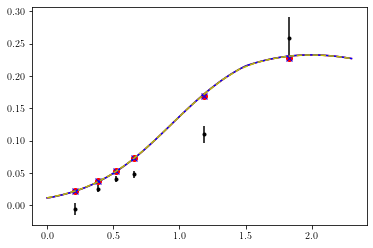

In [8]:
plt.errorbar(zs, data_bsfr, yerr=np.sqrt(np.diag(cov_bsfr)), fmt='k.')
zhi = np.linspace(0, 2, 128)

p0 = [12.94, 0.42, 1.75, 1.17]
pr = cib.HaloProfileCIBM21(cosmo, cM, fsub=0.134, fast_integ=False)
bsfr = get_pred_SFR(p0)
plt.plot(zs, bsfr, 'ro')
zhi, bsfr = get_pred_SFR(p0, convolve=False)
plt.plot(zhi, bsfr, 'r-')

pr = cib.HaloProfileCIBM21(cosmo, cM, fsub=0.134, fast_integ=True)
bsfr = get_pred_SFR(p0)
plt.plot(zs, bsfr, 'bx')
zhi, bsfr = get_pred_SFR(p0, convolve=False)
plt.plot(zhi, bsfr, 'b-')
zhi, bsfr = get_pred_SFR(p0, convolve=False, num_z=20)
plt.plot(zhi, bsfr, 'y--')
plt.show()

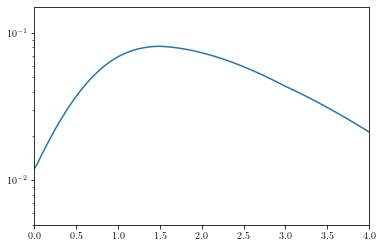

In [9]:
zhi, rsfr = get_pred_SFR(p0, convolve=False, num_z=100, SFR=True, zmax=4.0)
plt.plot(zhi, rsfr)
plt.xlim([0, 4])
plt.ylim([5E-3, 0.15])
plt.yscale('log')

In [10]:
pr = cib.HaloProfileCIBM21(cosmo, cM, fsub=0.134, fast_integ=True)
priors = [[10.5, 14.0], [0.0, 1.2], [0, 4], [0, 3]]

def out_prior(p):
    for par, prior in zip(p, priors):
        if (par < prior[0]) or (par > prior[1]):
            return True
    return False

def chi2_bsfr(p):
    if out_prior(p):
        return np.inf
    th = get_pred_SFR(p, num_z=20)
    r = th - data_bsfr
    chi2 = np.dot(r, np.dot(icov_bsfr, r))
    return chi2

def like_bsfr(p):
    return -0.5*chi2_bsfr(p)

In [11]:
pBF = minimize(chi2_bsfr, p0, method='Powell').x
print(pBF)

/home/damonge/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


[11.31104341  0.50113753  1.71885804  0.45386483]


In [12]:
nwalkers = 8
npars = len(pBF)
nsteps = 10000

pos = (pBF +
       0.001 * np.random.randn(nwalkers, npars))
sampler = emcee.EnsembleSampler(nwalkers, npars, like_bsfr)
sampler.run_mcmc(pos, nsteps, progress=True)

100%|██████████| 10000/10000 [15:12<00:00, 10.96it/s]


State([[11.09827398  0.39378165  2.01846446  0.1961688 ]
 [11.55611565  0.24665167  3.13272149  1.52837657]
 [11.06410392  0.45095424  1.97283808  0.17854851]
 [12.53450848  0.15031758  3.7098637   2.36253803]
 [11.1347502   0.20286944  3.99038067  2.11085773]
 [10.54079657  0.21558966  3.96240917  1.21362331]
 [12.20899726  0.20602567  3.24261011  1.6556175 ]
 [11.69479272  0.81825494  0.93344048  0.22194405]], log_prob=[-5.90803219 -5.43632819 -6.07241779 -9.6969636  -6.54835664 -5.07848519
 -7.59117802 -5.03650457], blobs=None, random_state=('MT19937', array([3021323719, 1059383657, 3428248174, 2805334345,  385504858,
       3736872599, 2930154691, 4003396189, 2823694733, 2311778403,
       3374673861, 3977085216, 1682258127, 3852082430, 4254008584,
        655203107,  341292210,  990573380, 3393339253, 2968007550,
       1815866153, 4062507161, 3946279121, 2151480704, 3336225583,
       2907684862,  774613058, 2493828680, 3340515016, 3464507040,
       1128340624, 3200908144, 11146

In [13]:
chain = sampler.get_chain(discard=500, flat=True)
np.savez('data/hm_constraints_kmax0p15.npz', chain=chain)

In [11]:
chain = np.load("data/hm_constraints_kmax0p15.npz")['chain']

Removed no burn in


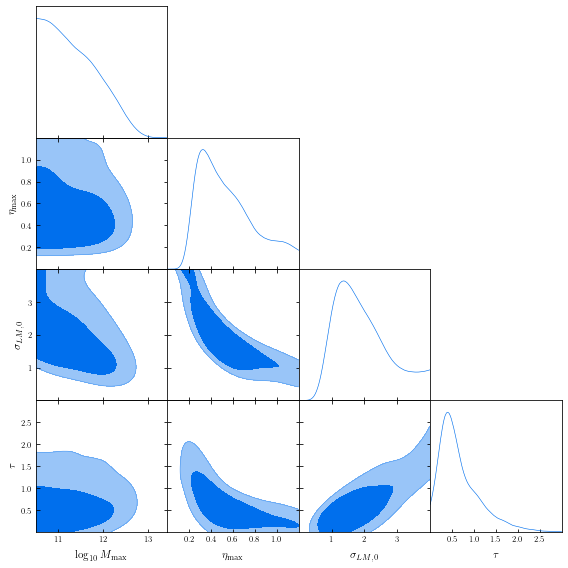

In [12]:
from getdist import MCSamples
from getdist import plots as gplots

nsamples = len(chain)
# Generate samples
samples = MCSamples(samples=chain,
                    names=['logM', 'eta', 'slm', 'tau'],
                    labels=[r'$\log_{10}M_{\rm max}$',
                            r'$\eta_{\rm max}$',
                            r'$\sigma_{LM,0}$',
                            r'$\tau$'],
                    ranges=priors)
samples.smooth_scale_2D=0.5

# Triangle plot
g = gplots.getSubplotPlotter()
g.triangle_plot([samples], filled=True)

In [13]:
pars = chain[np.random.choice(range(len(chain)), 500)]
curves_bsfr = np.array([get_pred_SFR(p, convolve=False, num_z=20)[1] for p in pars])
curves_rsfr = np.array([get_pred_SFR(p, convolve=False, num_z=20, SFR=True)[1] for p in pars])

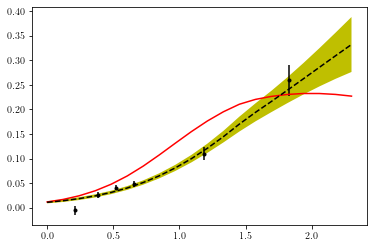

In [15]:
bsfr_mean = np.mean(curves_bsfr, axis=0)
bsfr_std = np.std(curves_bsfr, axis=0)
zhi, bsfr_M21 = get_pred_SFR(p0, convolve=False, num_z=20)
plt.errorbar(zs, data_bsfr, yerr=np.sqrt(np.diag(cov_bsfr)), fmt='k.')
plt.plot(zhi, bsfr_M21, 'r-')
plt.plot(zhi, bsfr_mean, 'k--')
plt.fill_between(zhi, bsfr_mean-bsfr_std, bsfr_mean+bsfr_std, facecolor='y')

In [17]:
np.savez('sfr_data_for_erc.npz',
         zs=zs, bsfr_d=data_bsfr,
         bsfr_e=np.sqrt(np.diag(cov_bsfr)),
         z=zhi, bsfr_hi=bsfr_mean+bsfr_std,
         bsfr_lo=bsfr_mean-bsfr_std)

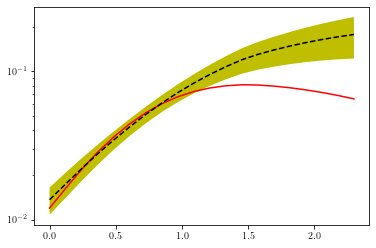

In [18]:
zhi, rsfr_M21 = get_pred_SFR(p0, convolve=False, num_z=20, SFR=True)
plt.plot(zhi, rsfr_M21, 'r-')
rsfr_mean = np.mean(curves_rsfr, axis=0)
rsfr_std = np.std(curves_rsfr, axis=0)
plt.plot(zhi, rsfr_mean, 'k--')
plt.fill_between(zhi, rsfr_mean-rsfr_std, rsfr_mean+rsfr_std, facecolor='y')
plt.yscale('log')

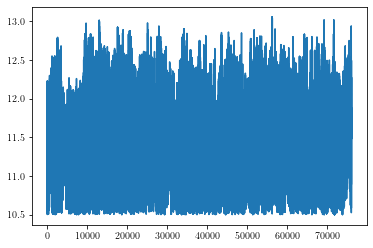

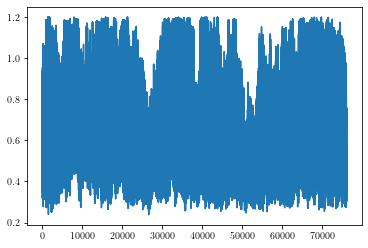

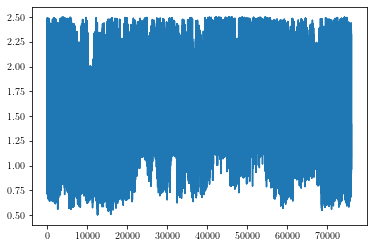

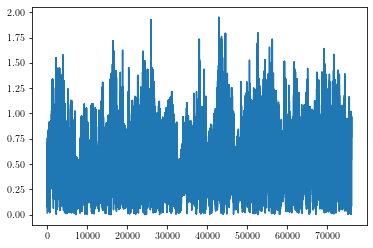

In [19]:
for c in chain.T:
    plt.figure()
    plt.plot(c)